**Student-t VaR Estimation: Tail-Risk Analysis for Heavy-Tailed Assets**

Estimates tail risk for a heavy-tailed asset using the Student-t distribution. It fits a Student-t to the simulated returns, estimates degrees of freedom via maximum likelihood, and computes Value-at-Risk (VaR) at multiple confidence levels, alongside Normal and empirical quantile VaR for comparison. The notebook also visualizes the return histogram with overlaid Student-t and Normal PDFs to illustrate tail behavior, demonstrating how parametric Student-t adjustments provide a more accurate assessment of extreme outcomes than standard Normal assumptions.

Estimated df: 5.508, loc: -0.000068, scale: 0.019313
Normal VaR: 0.040310
Student-t VaR: 0.038206
Empirical VaR: 0.039479


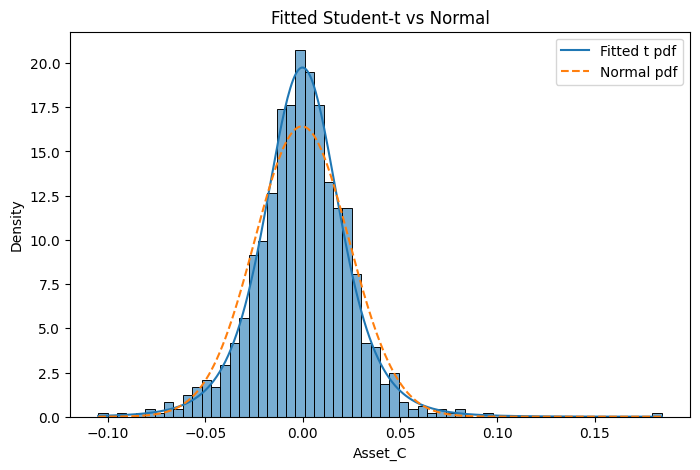

In [6]:
# Student-t VaR Estimation: Tail-Risk Analysis for Heavy-Tailed Assets
# Fit a Student-t to returns, estimate degrees of freedom (df) via MLE, and compute Student-t VaR. Compare with Normal and Empirical VaR.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import t, norm, moment

returns = pd.read_csv('data/simulated_returns.csv')
series = returns['Asset_C']

# Empirical VaR
def empirical_var(data, alpha=0.05):
    return -np.quantile(data, alpha)

# Student-t VaR
def student_t_var(alpha, data, df=4):
    mu = np.mean(data)
    sigma = np.std(data)
    T_ = t.ppf(alpha, df)
    return - (T_ * sigma * np.sqrt((df-2)/df)) - mu

# Fit degrees of freedom for Student-t using method-of-moments
def fit_student_t_df(data):
    # Approximate df from excess kurtosis
    excess_kurt = stats.kurtosis(data, fisher=True)
    df = 6 / excess_kurt + 4  # method-of-moments estimator
    return max(df, 2.1)  # df must be > 2

# Fit Student-t (scipy.stats.t.fit returns df, loc, scale)
df_hat, loc_hat, scale_hat = stats.t.fit(series)
print(f"Estimated df: {df_hat:.3f}, loc: {loc_hat:.6f}, scale: {scale_hat:.6f}")

# For VaR we map quantiles from t to empirical scale
alpha = 0.05
# Compute t-quantile with estimated df and map using fitted loc & scale
t_q = stats.t.ppf(alpha, df_hat)
student_var = - (loc_hat + scale_hat * t_q)

# Compare to parametric normal and empirical
mu, sigma = series.mean(), series.std(ddof=1)
normal_var = - (mu + sigma * stats.norm.ppf(alpha))
emp_var = empirical_var(series.values, alpha)  # <-- fixed argument order

print(f"Normal VaR: {normal_var:.6f}")
print(f"Student-t VaR: {student_var:.6f}")
print(f"Empirical VaR: {emp_var:.6f}")

# Visualize tails: histogram + theoretical t pdf overlay
x = np.linspace(series.min(), series.max(), 400)
plt.figure(figsize=(8,5))
sns.histplot(series, bins=60, stat='density', alpha=0.6)
plt.plot(x, stats.t.pdf((x - loc_hat)/scale_hat, df_hat)/scale_hat, label='Fitted t pdf')
plt.plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), linestyle='--', label='Normal pdf')
plt.legend()
plt.title('Fitted Student-t vs Normal')
plt.show()